In [29]:
import os,re,pickle
import datetime
import pytz
import multiprocessing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay


In [35]:
pd.__version__

'1.2.4'

In [3]:
data = pd.read_csv('../data/dataset_tweet_sentiment_cellular_service_provider.csv')
data.columns = ['id','sentiment','text_tweet']
data.head()

,id,sentiment,text_tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


<AxesSubplot:xlabel='sentiment', ylabel='count'>

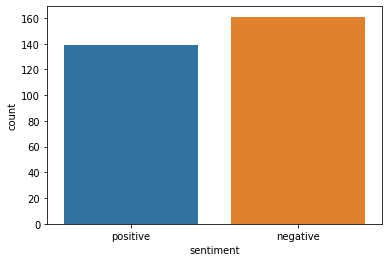

In [4]:
sns.countplot(data.sentiment)

In [5]:
data.sentiment.value_counts()

negative    161
positive    139
Name: sentiment, dtype: int64

In [6]:
data['sentiment_value'] = [1 if x=='positive' else 0 for x in data.sentiment]

### Text Preprocessing

In [7]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

slangwords = pd.read_csv("../data/list_slang_words.csv")
slangwords = slangwords[['slang','formal']]
dict_slang = slangwords.set_index('slang').T.to_dict('records')[0]

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# eng_stopwords = stopwords.words('english')
# idn_stopwords = stopwords.words('indonesian')

# stop_words = idn_stopwords + eng_stopwords

TOKENIZER = RegexpTokenizer(r'\w+')

def process_text(word):
    final = []
    word = str(word).lower().strip()
    soup = BeautifulSoup(word, "html.parser")
  
    for data in soup(['style', 'script']):
        data.decompose()
    word = ' '.join(soup.stripped_strings)
    
    for token in TOKENIZER.tokenize(word):
        if len(token) > 1: 
            if token in dict_slang.keys():
                token = dict_slang[token]
            final.append(token)
    word = " ".join(final).strip()
    word = stemmer.stem(word)
        
                
    return word

In [8]:
%time data["clean_text"] = data.text_tweet.apply(lambda x:process_text(x))

CPU times: user 41.4 s, sys: 224 ms, total: 41.6 s
Wall time: 41.8 s


In [9]:
data.head()

,id,sentiment,text_tweet,sentiment_value,clean_text
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,1,boikot guna produk bangsa sendiri
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",1,sakti balik lagi alhamdulillah
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,0,selamat pagi bisa bantu kenapa di dalam kamar ...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,0,dear akhir2 ini jaring data lot banget padahal
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,0,selamat malam dusta


### Feature Extraction

In [10]:
tfidf = TfidfVectorizer(ngram_range=(1,3))

In [11]:
X = data[['clean_text']]
y = data['sentiment_value']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
tfidf.fit(X_train['clean_text'])

TfidfVectorizer(ngram_range=(1, 3))

In [14]:
x_train_tfidf = tfidf.transform(X_train['clean_text'])

In [16]:
x_test_tfidf = tfidf.transform(X_test['clean_text'])

In [17]:
x_train_tfidf.shape

(225, 3867)

In [18]:
x_test_tfidf.shape

(75, 3867)

### Model

In [30]:
# model = RandomForestClassifier()
model = SVC(C=1.0, kernel='linear', random_state=42)


In [31]:
model.fit(x_train_tfidf,y_train)
pickle.dump(model, open(f"../model/model_svc_iter_1.pkl", 'wb'))

In [32]:
y_pred = model.predict(x_test_tfidf)


In [33]:
def evaluation_metrix(actual,prediction,model):
    print(f"accuracy : {accuracy_score(actual,prediction)}")
    print(f"F1-Score : {f1_score(actual,prediction)}")
    print(f"ROC AUC Score : {roc_auc_score(actual,prediction,average='macro')}")
    print("-"*50)
    print("confusion matrix")
    cm = confusion_matrix(actual,prediction,labels=model.classes_)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot() 
    plt.show()
    print("-"*50)
    print(classification_report(actual,prediction))

accuracy : 0.84
F1-Score : 0.793103448275862
ROC AUC Score : 0.8246753246753247
--------------------------------------------------
confusion matrix
[[40  2]
 [10 23]]


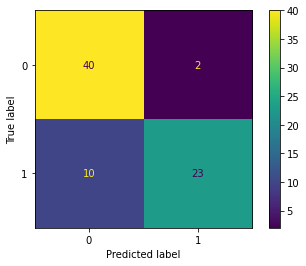

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        42
           1       0.92      0.70      0.79        33

    accuracy                           0.84        75
   macro avg       0.86      0.82      0.83        75
weighted avg       0.85      0.84      0.84        75



In [34]:
evaluation_metrix(y_test,y_pred,model)